In [2]:
import pandas as pd
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from decimal import Decimal
fs = 16  # Fontsize

def gaussian( mu, sigma, x):
    return np.exp( - np.power( x - mu, 2. ) / ( 2. * np.power( sigma, 2. )  ) )

In [4]:
# Bunch params
numPart = int(1e6)
fn = 'initialDistro_N1e6.in'
Q = 1e-9  # Charge
q = Q / numPart  # Charge per particle
Ne = Q / 1.602e-19
print('Real number of electrons = ', Ne)
print('Electrons per macro-particle = ', '%.2e' % Decimal( Ne / numPart ) )
    
avgE = 48.12  # Energy in MeV
sigE = .03
DeltaE = .1  # In MeV, the oscillations of the energy modulation
c = 3e8
gamma = avgE / .511
beta = np.sqrt( 1 - 1 / np.power(gamma,2) )
print('beta = ', beta, '\ngamma = ', gamma)

K = 11.1
lu = 8.5e-2
gamma_ = gamma / np.sqrt( 1 + .5 * np.power(K,2.) )
beta_ = np.sqrt( 1 - 1 / np.power(gamma_,2.) )
print('beta_ = ', beta_, '\ngamma_ = ', gamma_)
lr = lu / 2 / np.power(gamma_,2)
print( 'lu = ', '%.2e' % Decimal(lu), '\nlr = ', '%.2e' % Decimal(lr) )
kr = 2*np.pi / lr
ku = 2*np.pi / lu
print('beta / beta_ = ', beta / beta_)
print('beta_ / beta = ', beta_ / beta)

sigr = 500e-6
print('transverse spread = ', '%.2e' % Decimal(sigr) )
epsr = .5e-6  # Normalised transverse emittance
sigpr = epsr / sigr  # Assuming sigr and sigpr uncorrelated gaussian distro
print('average momentum = ', '%.2e' % Decimal(beta*gamma), '\ntransverse momentum spread = ', '%.2e' % Decimal(sigpr) )

# Time that simulation should last
# To complete once lTrun is known
# Lu = 10 * lu
# lTrun = 1
# lmin = lTrun * beta / beta_ - 5 * lu * ( 1 + beta / beta_ )
# lcent = lmin - lTrun / ( 1 - beta_ * beta )
# print( 'lmin in lab frame = ', lmin, ', lcent in lab frame is = ', lcent)
# timeDiff = beta_ / c / ( 1 - beta_ * beta ) * lTrun
# print('time difference in lab frame between center and maxZ particle is ', timeDiff)
# totTime =  2 * -lcent / beta / c + Lu / beta_ / c
# print( 'simulation time = ', totTime )


Real number of electrons =  6242197253.433209
Electrons per macro-particle =  6.24e+03
beta =  0.9999436138020628 
gamma =  94.16829745596868
beta_ =  0.9964637892080291 
gamma_ =  11.901459103308694
lu =  8.50e-02 
lr =  3.00e-04
beta / beta_ =  1.0034921736562041
beta_ / beta =  0.9965199791808237
transverse spread =  5.00e-04
average momentum =  9.42e+01 
transverse momentum spread =  1.00e-03


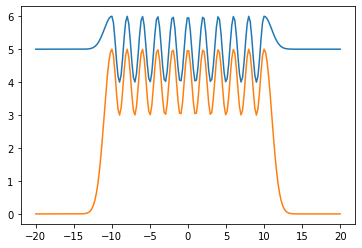

In [5]:
# Make the shape. Note that it is all done in pico seconds
# First make modulation and Gaussian
T = 2  # Period of modulation profile
tFT = 20  # Time flattop
x = np.linspace( -.5*tFT, .5*tFT, 100)
yMod = np.cos( 2 * np.pi / T * x )
sigGauss = 1  # std of the half-gaussians
xGauss = np.linspace( .5*tFT, tFT, 50 )
yHalfGauss = gaussian( .5*tFT, sigGauss, xGauss )

# Make shape for energy
xE = np.concatenate(( np.flip(-xGauss), x, xGauss  ))
yE =  np.concatenate(( np.flip(yHalfGauss), yMod, yHalfGauss  ))
plt.plot(xE,yE+5)

# Make shape for density modulation
xDen = xE
yDen =  np.concatenate(( np.flip(5*yHalfGauss), 4 + yMod, 5*yHalfGauss  ))

# Make shape for density w/o modulation (comment this part if you want modulation)
# tFT = 15  # Time flattop
# x = np.linspace( -.5*tFT, .5*tFT, 100)
# sigGauss = 3.2  # std of the half-gaussians
# cutoff = 5  # Cutoff in number of sigmas
# xGauss = np.linspace( .5*tFT, .5*tFT + cutoff*sigGauss, 50 )
# yHalfGauss = gaussian( .5*tFT, sigGauss, xGauss )
# xDen = np.concatenate(( np.flip(-xGauss), x, xGauss  ))
# yMod = np.ones(len(x))
# yDen =  np.concatenate(( np.flip(5*yHalfGauss), 4 + yMod, 5*yHalfGauss  ))


plt.plot(xDen, yDen)

plt.show()




In [6]:
# Make the longitudinal time coordinate
f = interpolate.interp1d( xDen, yDen )
zt = []
while len(zt) < numPart:
    xr = np.random.uniform( -15, 15 )
    yr = np.random.uniform( 0.0, 5.5 )
    if yr <= f(xr):
        zt.append(xr)
# picoSeconds to seconds
zt = np.array(zt)*1e-12


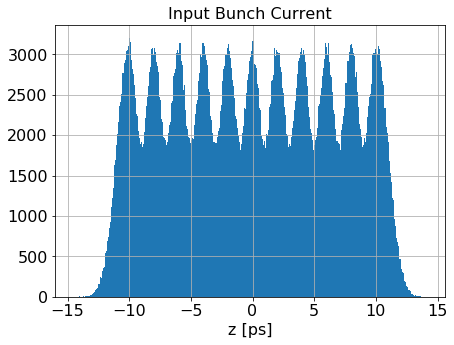

In [7]:
# Plot bunch current
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
nbins = 500
ax.hist( zt*1e12, bins = nbins)
ax.grid()
ax.set_xlabel('z [ps]', fontsize = fs)
ax.tick_params( axis = 'both', labelsize = fs )
fig.set_size_inches( 7, 5 )
ax.set_title('Input Bunch Current', fontsize = fs)
#plt.savefig('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/awa_masters/shared_docs/awa_meeting_19_11_14/img/macArthur/initialCurrent.eps', bbox_inches='tight')
plt.show()


In [8]:
# Make the rest of the distro

# Longitudinal beam size
z = np.array( zt * beta * c )
z -= np.average(z)

# Transverse beam size
x = np.random.normal( 0, sigr, len(z))
y = np.random.normal( 0, sigr, len(z))

# Energy
E = np.random.normal( avgE, sigE, len(z))  # in MeV
f = interpolate.interp1d( xE * 1e-12 * beta * c, yE )
E += DeltaE * f(z)

# Transverse momenta
px = np.random.normal( 0, sigpr, len(z))
py = np.random.normal( 0, sigpr, len(z))

# Longitudinal momentum
pz = []
for i in range(len(z)):
    g = E[i] / .511
    gb2 = np.power(g,2.) * ( 1 - 1 / np.power(g,2) )
    pz.append( np.sqrt( gb2 - np.power(px[i],2.) - np.power(py[i],2.) ) )

print('p = ', np.average(px), ', ', np.average(py), ', ', np.average(pz))

p =  -3.1515559050351727e-07 ,  1.5737817262849393e-07 ,  94.2014928199821


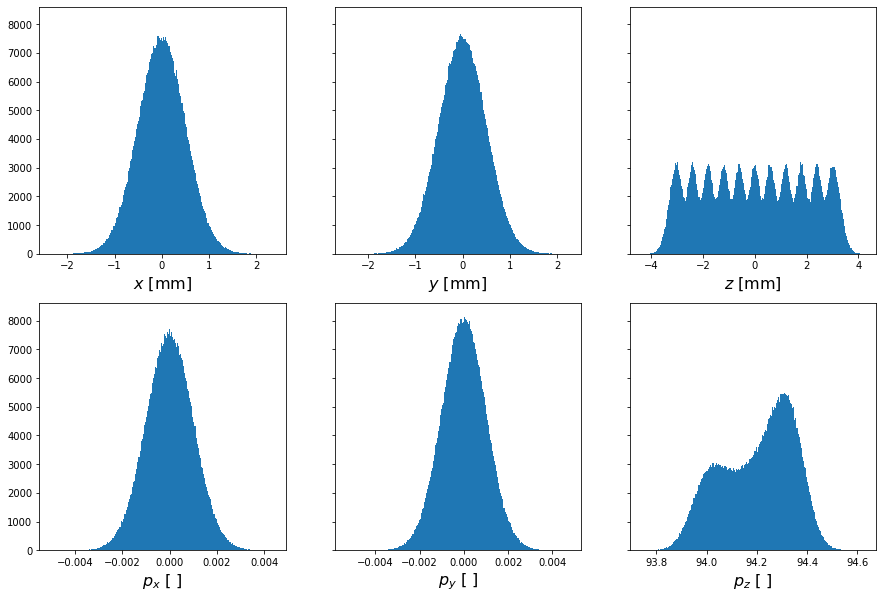

In [9]:
# Plot bunch parameters

fig, ax = plt.subplots( 2, 3, sharey = True)
fig.set_size_inches(15, 10)
ax[0,0].hist( x*1e3, bins = nbins )
ax[0,0].set_xlabel('$x$ [mm]', fontsize = fs)
ax[0,1].hist( y*1e3, bins = nbins )
ax[0,1].set_xlabel('$y$ [mm]', fontsize = fs)
ax[0,2].hist( z*1e3, bins = nbins )
ax[0,2].set_xlabel('$z$ [mm]', fontsize = fs)
ax[1,0].hist( px, bins = nbins )
ax[1,0].set_xlabel('$p_x$ [ ]', fontsize = fs)
ax[1,1].hist( py, bins = nbins )
ax[1,1].set_xlabel('$p_y$ [ ]', fontsize = fs)
ax[1,2].hist( pz, bins = nbins )
ax[1,2].set_xlabel('$p_z$ [ ]', fontsize = fs)
plt.show()


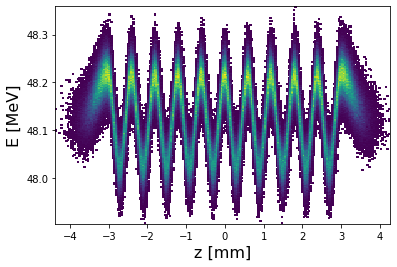

In [11]:
plt.hist2d(z*1e3, E, bins = 200, cmin = 1)
#plt.ylim( bottom = 48, top = 52 )
plt.xlabel('z [mm]', fontsize = fs)
plt.ylabel('E [MeV]', fontsize = fs)
plt.show()


In [12]:
# Write to file

file = open( fn, mode = 'w' )
file.write( str( str(numPart) + '\n' ) )
file.close()

df = pd.DataFrame([x,px,y,py,z,pz])
df = df.T
df.to_csv( fn, sep = '\t', header = False, index = False, mode = 'a' )